In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

import numpy as np

# set seed for numpy and torch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.convolution import convolve, Gaussian2DKernel

def _draw_counts(n_exp, s_min, s_max, beta):
    """
    Draw subhalo masses from SHMF with slope `beta` and min/max masses `m_sub_min` and `m_sub_max` . Stolen from:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    n_sub = np.random.poisson(n_exp)
    u = np.random.uniform(0, 1, size=n_sub)
    s_low_u, s_high_u = s_min ** (beta + 1), s_max ** (beta + 1)
    return n_sub, (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (beta + 1.0))

def _convolve_psf(image, fwhm_psf=2., pixel_size=1):
    """
    Convolve input map of pixel_size with Gaussian PSF of with FWHM `fwhm_psf`
    """
    sigma_psf = fwhm_psf / 2 ** 1.5 * np.sqrt(np.log(2))  # Convert FWHM to standard deviation
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    return convolve(image, kernel)


In [3]:
n_x, n_y = 32, 32

In [4]:
def simulator_model(parameter, return_points=False):

    alpha, beta = parameter

    the_map = np.zeros(n_x * n_y)
    n_sub, s_exp = _draw_counts(alpha, 0.1, 100, beta)
    pos = np.random.permutation(np.arange(n_x * n_y))[:n_sub]
    np.add.at(the_map, pos, s_exp)
    the_map = the_map.reshape((n_x, n_y))
    the_map = _convolve_psf(the_map)
    the_map = np.random.poisson(the_map)
    the_map = the_map.reshape(1,-1)
    return torch.tensor(the_map, dtype=torch.get_default_dtype())

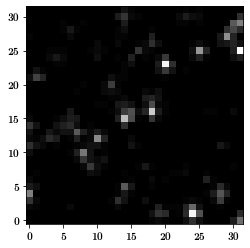

In [5]:
plt.imshow(simulator_model([100.1, -0.9]).view(n_x, n_y), origin='lower', cmap='gray')

In [7]:
class SummaryNet(nn.Module): 

    def __init__(self): 
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=8, stride=8)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=6*4*4, out_features=8) 

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6*4*4)
        x = F.relu(self.fc(x))
        return x

embedding_net_og = SummaryNet()


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

embedding_net = Net()

In [16]:
simulator_model([100.1, -0.9]).shape

torch.Size([1, 1024])

In [15]:
embedding_net_og(simulator_model([100.1, -0.9])).shape

torch.Size([1, 8])

In [114]:
from torchvision import models
from torchsummary import summary

In [116]:
summary(embedding_net, input_size=(1, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [95]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.0, -1.99]), 
                             high=torch.tensor([700.0, -0.2]))                           

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = inference.prepare_for_sbi(simulator_model, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=4)

# setup the inference procedure with the SNPE-C procedure
inference_inst = inference.SNPE(simulator_wrapper, prior, 
                           density_estimator=neural_posterior, 
                           show_progress_bars=True)

# run the inference procedure on one round and 10000 simulated data points
posterior = inference_inst(num_simulations=10000)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 2-dimensional input of size [1, 1024] instead

In [86]:
# generate posterior samples
true_parameter = torch.tensor([400, -0.4])
x_observed = simulator_model(true_parameter)
samples = posterior.set_default_x(x_observed).sample((50000,))

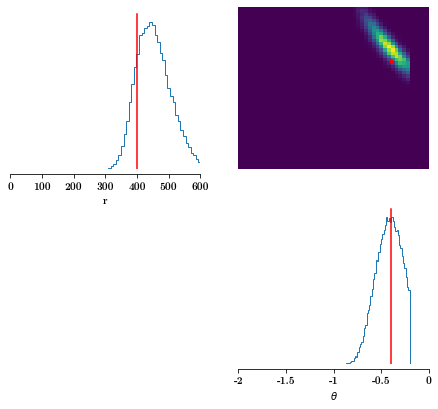

In [87]:
# create the figure
fig, ax = utils.pairplot(samples, 
                             points=true_parameter,
                             labels=['r', r'$\theta$'], 
                             limits=[[0, 600], [-2, 0]],
                             points_colors='r',
                             points_offdiag={'markersize': 6},
                             fig_size=[7.5, 6.4])


In [4]:
import sys
sys.path.append("../deepsphere-pytorch/")
sys.path.append("../")

In [5]:
from deepsphere.layers.chebyshev import SphericalChebConv
from deepsphere.utils.laplacian_funcs import get_healpix_laplacians

In [6]:
import torch
from torch import nn

from deepsphere.layers.samplings.equiangular_pool_unpool import Equiangular
from deepsphere.layers.samplings.healpix_pool_unpool import Healpix
from deepsphere.layers.samplings.icosahedron_pool_unpool import Icosahedron
from deepsphere.models.spherical_unet.decoder import Decoder
from deepsphere.models.spherical_unet.encoder import Encoder, EncoderTemporalConv
from deepsphere.utils.laplacian_funcs import get_healpix_laplacians
from deepsphere.utils.utils import healpix_graph, healpix_laplacian, healpix_weightmatrix

In [24]:
class SphericalChebBNPool(nn.Module):
    """Building Block with a pooling/unpooling, a calling the SphericalChebBN block.
    """

    def __init__(self, in_channels, out_channels, lap, pooling, kernel_size):
        """Initialization.

        Args:
            in_channels (int): initial number of channels.
            out_channels (int): output number of channels.
            lap (:obj:`torch.sparse.FloatTensor`): laplacian.
            pooling (:obj:`torch.nn.Module`): pooling/unpooling module.
            kernel_size (int, optional): polynomial degree. Defaults to 3.
        """
        super().__init__()
        self.spherical_cheb = SphericalChebConv(in_channels, out_channels, lap, kernel_size)
        self.pooling = pooling
        self.batchnorm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        """Forward Pass.

        Args:
            x (:obj:`torch.tensor`): input [batch x vertices x channels/features]

        Returns:
            :obj:`torch.tensor`: output [batch x vertices x channels/features]
        """
        x = self.spherical_cheb(x)
        x = self.batchnorm(x.permute(0, 2, 1))
        x = F.relu(x.permute(0, 2, 1))
        x = self.pooling(x)
        return x


In [109]:
class SphericalGraphCNN(nn.Module):
    """Spherical GCNN Autoencoder.
    """

    def __init__(self, N, kernel_size=4):
        """Initialization.

        Args:
            pooling_class (obj): One of three classes of pooling methods
            N (int): Number of pixels in the input image
            kernel_size (int): chebychev polynomial degree
        """
        super().__init__()
        self.kernel_size = kernel_size
        self.pooling_class = Healpix()
        self.laps = get_healpix_laplacians(N, 2, "normalized") #get_healpix_laplacians(N, depth, laplacian_type)

        self.spherical_cheb_bn_pool = SphericalChebBNPool(3072, 768, self.laps[1], self.pooling_class.pooling, self.kernel_size)

    def forward(self, x):
        """Forward Pass.

        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.

        Returns:
            :obj:`torch.Tensor`: output
        """
        return self.spherical_cheb_bn_pool(x)

In [110]:
import healpy as hp
npix = hp.nside2npix(16)
test_map = np.ones(npix)

In [111]:
sg = SphericalGraphCNN(npix)

In [112]:
# G = healpix_graph(nside=128)

In [114]:
in_map = torch.tensor(test_map.reshape((1,-1,1)))
sg(in_map)

RuntimeError: shape '[3072, 3072]' is invalid for input of size 3072

In [103]:
get_healpix_laplacians(npix, 2, "combinatorial")

[tensor(indices=tensor([[  0,   0,   0,  ..., 767, 767, 767],
                        [  0,   1,   2,  ..., 765, 766, 767]]),
        values=tensor([ 0.3212, -0.2478, -0.2478,  ..., -0.2478, -0.2478,
                        0.3212]),
        size=(768, 768), nnz=7032, layout=torch.sparse_coo),
 tensor(indices=tensor([[   0,    0,    0,  ..., 3071, 3071, 3071],
                        [   0,    1,    2,  ..., 3069, 3070, 3071]]),
        values=tensor([ 0.3047, -0.2438, -0.2438,  ..., -0.2438, -0.2438,
                        0.3047]),
        size=(3072, 3072), nnz=27960, layout=torch.sparse_coo)]

In [16]:
# from pygsp.graphs.nngraphs.spherehealpix import SphereHealpix

In [17]:
# G = SphereHealpix(nside=16, n_neighbors=8)
# G.compute_laplacian("normalized")


In [18]:
# G.L

In [5]:
import sys
sys.path.append("../../DeepSphere/")

In [7]:
from deepsphere.utils import healpix_graph, healpix_laplacian

In [14]:
healpix_laplacian(nside=128)

<196608x196608 sparse matrix of type '<class 'numpy.float32'>'
	with 1769448 stored elements in Compressed Sparse Row format>